In [29]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers.core import Dense
from keras.optimizers import RMSprop
from keras.layers import LSTM, Dropout
from rbf_layer import RBFLayer, InitCentersRandom
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression

In [30]:
COMPANY = 'mbk'

In [31]:
def roll_beta(window_size, stock, market):
    data = {'X': market, 'Y': stock}
    df = pd.DataFrame(data)
    cov = df.X.rolling(window=window_size).cov(df.Y)
    var = df.X.rolling(window=window_size).var()
    roling_beta = cov/var
    return np.array(roling_beta[window_size - 1:])

In [32]:
def return_from_stock(stock_data):
    stock = pd.read_csv(f"{stock_data}")
    #creating new column 'return' it is percentage change between current and last month close price
    stock['return'] = stock.Zamkniecie.pct_change()
    return np.array(stock['return'][1:]) # first value is NaN so [1:]

In [33]:
wig_20_return = return_from_stock('wig20_m.csv')
peo_return = return_from_stock('mbk_m.csv')

In [34]:
peo_roll_beta = roll_beta(36, peo_return, wig_20_return)

In [35]:
peo_roll_beta

array([1.07094795, 1.08187114, 1.15249056, 0.82949287, 0.80774733,
       0.92045057, 0.93134374, 0.96164816, 1.00616151, 0.99002293,
       1.03669953, 1.05047408, 1.00945346, 1.00969909, 1.01319777,
       1.0226841 , 1.02282024, 1.02561317, 1.08835846, 1.11576006,
       1.23968671, 1.2287294 , 1.24785612, 1.26058833, 1.24549777,
       1.27202512, 1.33666696, 1.35322699, 1.42183138, 1.54853359,
       1.53728457, 1.52887522, 1.60913514, 1.6766105 , 1.64148846,
       1.75239983, 1.7704071 , 1.7929607 , 1.69695445, 1.78555264,
       1.78738714, 1.77654259, 1.73491279, 1.74232685, 1.7225966 ,
       1.75738156, 1.71423853, 1.71644784, 1.70568207, 1.70731538,
       1.69621505, 1.69912881, 1.66002137, 1.66716547, 1.66663239,
       1.66911945, 1.64390123, 1.64936454, 1.66727975, 1.66020622,
       1.66629732, 1.68465031, 1.68600573, 1.6741262 , 1.65149604,
       1.60467722, 1.6613008 , 1.66901518, 1.59696269, 1.49132735,
       1.54259349, 1.32461799, 1.31972091, 1.27526048, 1.38503

In [36]:
# creating training dataset
df_data = pd.DataFrame({
    'target': peo_roll_beta,
    't-1': np.roll(peo_roll_beta, 1),
    't-2': np.roll(peo_roll_beta, 2),
    't-3': np.roll(peo_roll_beta, 3),
    't-4': np.roll(peo_roll_beta, 4),
    't-5': np.roll(peo_roll_beta, 5)
})


In [37]:
df_data = df_data.iloc[5:]
df_data

,target,t-1,t-2,t-3,t-4,t-5
5,0.920451,0.807747,0.829493,1.152491,1.081871,1.070948
6,0.931344,0.920451,0.807747,0.829493,1.152491,1.081871
7,0.961648,0.931344,0.920451,0.807747,0.829493,1.152491
8,1.006162,0.961648,0.931344,0.920451,0.807747,0.829493
9,0.990023,1.006162,0.961648,0.931344,0.920451,0.807747
...,...,...,...,...,...,...
200,1.447013,1.452687,1.469534,1.486488,1.400199,1.429591
201,1.439441,1.447013,1.452687,1.469534,1.486488,1.400199
202,1.397923,1.439441,1.447013,1.452687,1.469534,1.486488
203,1.456381,1.397923,1.439441,1.447013,1.452687,1.469534


In [38]:
X = df_data.iloc[:, -5:]
X

,t-1,t-2,t-3,t-4,t-5
5,0.807747,0.829493,1.152491,1.081871,1.070948
6,0.920451,0.807747,0.829493,1.152491,1.081871
7,0.931344,0.920451,0.807747,0.829493,1.152491
8,0.961648,0.931344,0.920451,0.807747,0.829493
9,1.006162,0.961648,0.931344,0.920451,0.807747
...,...,...,...,...,...
200,1.452687,1.469534,1.486488,1.400199,1.429591
201,1.447013,1.452687,1.469534,1.486488,1.400199
202,1.439441,1.447013,1.452687,1.469534,1.486488
203,1.397923,1.439441,1.447013,1.452687,1.469534


In [39]:
X = X[X.columns[::-1]]
X

,t-5,t-4,t-3,t-2,t-1
5,1.070948,1.081871,1.152491,0.829493,0.807747
6,1.081871,1.152491,0.829493,0.807747,0.920451
7,1.152491,0.829493,0.807747,0.920451,0.931344
8,0.829493,0.807747,0.920451,0.931344,0.961648
9,0.807747,0.920451,0.931344,0.961648,1.006162
...,...,...,...,...,...
200,1.429591,1.400199,1.486488,1.469534,1.452687
201,1.400199,1.486488,1.469534,1.452687,1.447013
202,1.486488,1.469534,1.452687,1.447013,1.439441
203,1.469534,1.452687,1.447013,1.439441,1.397923


In [40]:
y = df_data.target
y

5      0.920451
6      0.931344
7      0.961648
8      1.006162
9      0.990023
         ...   
200    1.447013
201    1.439441
202    1.397923
203    1.456381
204    1.474655
Name: target, Length: 200, dtype: float64

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0, shuffle=False)

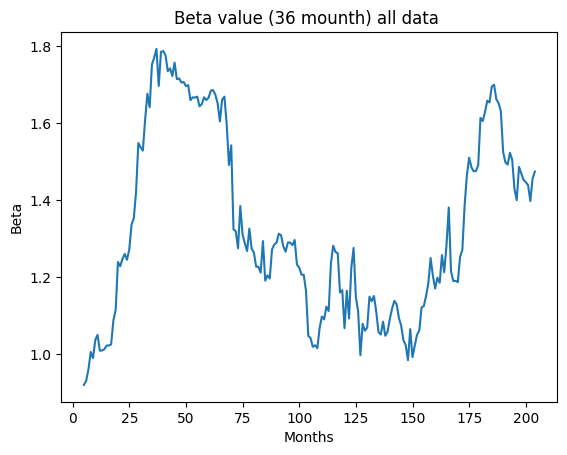

In [42]:
plt.plot(y)
plt.xlabel('Months')
plt.ylabel('Beta')
plt.title('Beta value (36 mounth) all data ')
plt.savefig(f'all_data{COMPANY}.png')

In [43]:
y_test

165    1.282760
166    1.381133
167    1.215120
168    1.190383
169    1.190691
170    1.187382
171    1.253032
172    1.271129
173    1.386229
174    1.464717
175    1.510545
176    1.485813
177    1.474990
178    1.475835
179    1.491007
180    1.613864
181    1.605626
182    1.629399
183    1.658525
184    1.653924
185    1.695620
186    1.699703
187    1.662425
188    1.652202
189    1.630682
190    1.525393
191    1.498400
192    1.492680
193    1.523255
194    1.504767
195    1.429591
196    1.400199
197    1.486488
198    1.469534
199    1.452687
200    1.447013
201    1.439441
202    1.397923
203    1.456381
204    1.474655
Name: target, dtype: float64

In [44]:
def single_plot(y_pred, y_real, title):
    x = np.arange(1, len(y_pred) + 1)
    plt.plot(x,y_real, label='real')
    plt.plot(x,y_pred, label='predicted')
    plt.xlabel('day')
    plt.ylabel('month')
    plt.legend()
    plt.title(title)
    return plt.plot()

In [45]:
def generate_plots(y_pred_train, y_pred_test, y_train, y_test, title_1, title_2, to_png, png_name):
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 6))

    ax = axes[0]  # Wybór odpowiedniej osi
    plt.sca(ax)  # Ustawienie bieżącej osi
    single_plot(y_pred_train, y_train, title_1)

    ax = axes[1]  # Wybór odpowiedniej osi
    plt.sca(ax)  # Ustawienie bieżącej osi
    single_plot(y_pred_test, y_test, title_2)

    plt.tight_layout()
    if to_png:
        plt.savefig(f'{png_name}.png')
    plt.show()

## Bulding RBF network model

In [46]:
model = Sequential()
rbflayer = RBFLayer(10,
                    initializer=InitCentersRandom(X_train),
                    betas=2.0,
                    input_shape=(5,))
model.add(rbflayer)
model.add(Dense(1))

model.compile(loss='mean_squared_error',
              optimizer=RMSprop())


model.fit(X_train, y_train,
          batch_size=10,
          epochs=200,
          verbose=1)

Epoch 1/200
16/16 [==============================] - 0s 2ms/step - loss: 1.8709
Epoch 2/200
16/16 [==============================] - 0s 2ms/step - loss: 1.4528
Epoch 3/200
16/16 [==============================] - 0s 3ms/step - loss: 1.1432
Epoch 4/200
16/16 [==============================] - 0s 2ms/step - loss: 0.8809
Epoch 5/200
16/16 [==============================] - 0s 1ms/step - loss: 0.6589
Epoch 6/200
16/16 [==============================] - 0s 1ms/step - loss: 0.4840
Epoch 7/200
16/16 [==============================] - 0s 2ms/step - loss: 0.3480
Epoch 8/200
16/16 [==============================] - 0s 1ms/step - loss: 0.2492
Epoch 9/200
16/16 [==============================] - 0s 2ms/step - loss: 0.1783
Epoch 10/200
16/16 [==============================] - 0s 1ms/step - loss: 0.1277
Epoch 11/200
16/16 [==============================] - 0s 1ms/step - loss: 0.0909
Epoch 12/200
16/16 [==============================] - 0s 1ms/step - loss: 0.0636
Epoch 13/200
16/16 [=================

2/2 [==============================] - 0s 0s/step


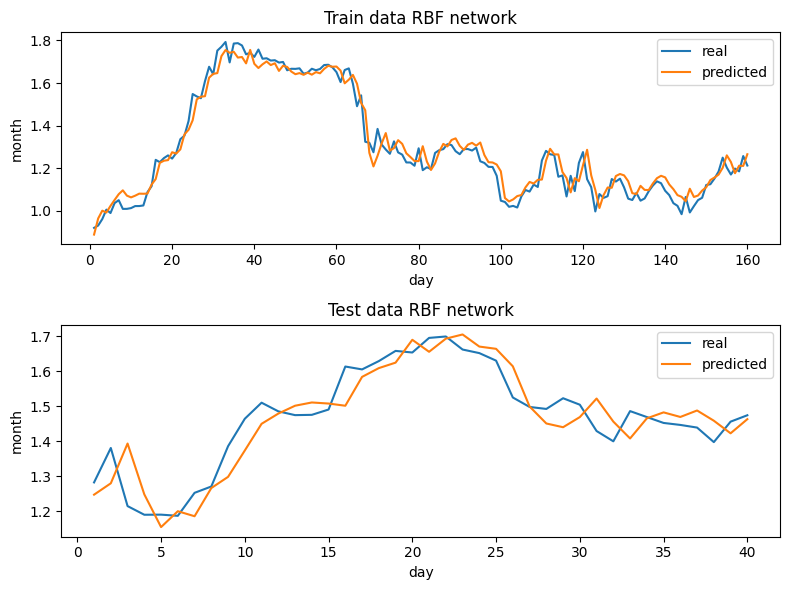

In [47]:
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)
generate_plots(y_pred_train, y_pred_test, y_train, y_test, 'Train data RBF network', 'Test data RBF network', True, f'RBF_{COMPANY}')

In [48]:
import matplotlib.pyplot as plt

def score_table(y_train, y_pred_train, y_test, y_pred_test, title):
    mse_train = mean_squared_error(y_train, y_pred_train)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    r2_train = r2_score(y_train, y_pred_train)

    mse_test = mean_squared_error(y_test, y_pred_test)
    mae_test = mean_absolute_error(y_test, y_pred_test)
    r2_test = r2_score(y_test, y_pred_test)
    # Tworzenie tabeli
    data = {'data': ['train', 'test'],
            'MSE': [round(mse_train, 3), round(mse_test, 3)],
            'MAE': [round(mae_train, 3), round(mae_test, 3)],
            'R^2': [round(r2_train, 3), round(r2_test, 3)]
            }

    df = pd.DataFrame(data)

    # Tworzenie wykresu tabeli
    fig, ax = plt.subplots()  # Ustalenie rozmiaru wykresu
    ax.axis('off')  # Wyłączenie osi

    table = ax.table(cellText=df.values, colLabels=df.columns, cellLoc='center', loc='center')
    # Zapisywanie tabeli jako obraz PNG
    plt.savefig(f'tabela{title}.png', bbox_inches='tight', pad_inches=0.5)
    plt.show()

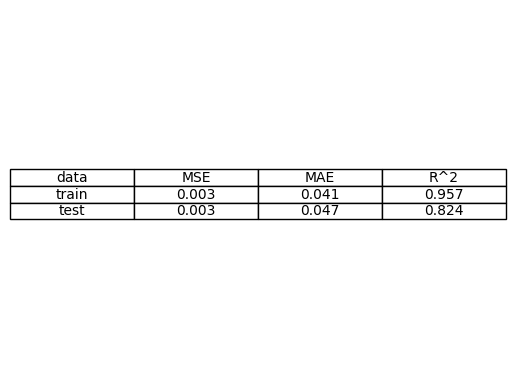

In [49]:
score_table(y_train, y_pred_train, y_test, y_pred_test, f'RBF_{COMPANY}')

## Bulding XGBRegressor model

In [57]:
from xgboost import XGBRegressor
my_model = XGBRegressor(n_estimators=1000)
my_model.fit(X_train, y_train, verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

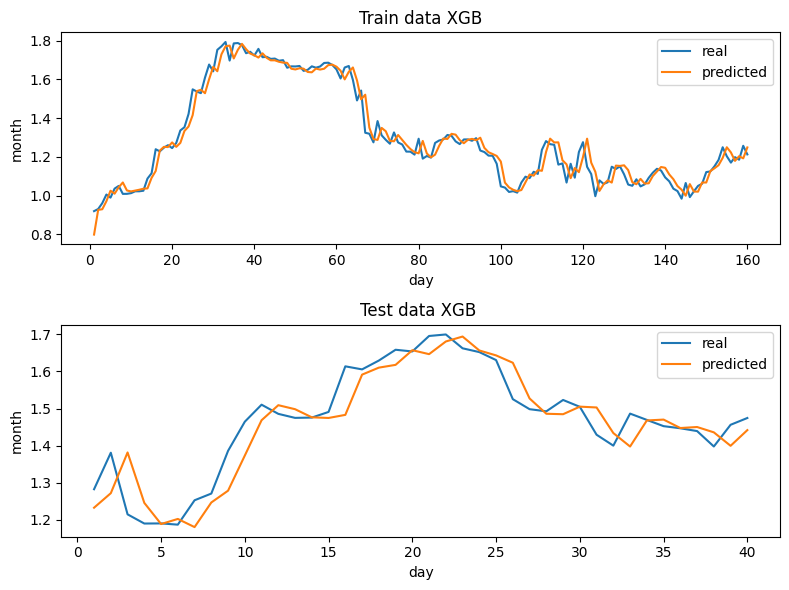

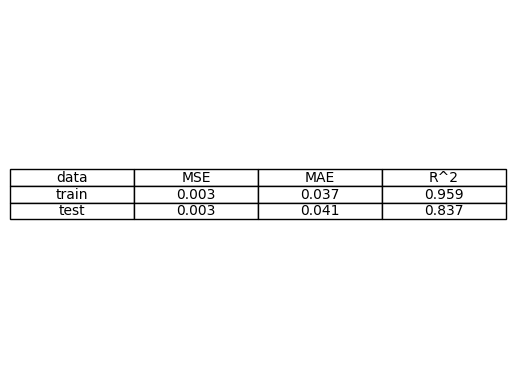

In [58]:
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)
generate_plots(y_pred_train, y_pred_test, y_train, y_test, 'Train data XGB', 'Test data XGB ', True, f'XGB_{COMPANY}')
score_table(y_train, y_pred_train, y_test, y_pred_test, f'XGB_table_{COMPANY}')

In [61]:
xd = 55555
xd

55555

## Bulding LSTM network

In [52]:
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(100, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(100, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 5, 100)            40800     
                                                                 
 dropout_2 (Dropout)         (None, 5, 100)            0         
                                                                 
 lstm_4 (LSTM)               (None, 5, 100)            80400     
                                                                 
 dropout_3 (Dropout)         (None, 5, 100)            0         
                                                                 
 lstm_5 (LSTM)               (None, 100)               80400     
                                                                 
 dense_4 (Dense)             (None, 25)                2525      
                                                                 
 dense_5 (Dense)             (None, 1)                

In [53]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size= 1, epochs=20)

Epoch 1/20
160/160 [==============================] - 5s 5ms/step - loss: 0.0972
Epoch 2/20
160/160 [==============================] - 1s 6ms/step - loss: 0.0223
Epoch 3/20
160/160 [==============================] - 1s 5ms/step - loss: 0.0172
Epoch 4/20
160/160 [==============================] - 1s 6ms/step - loss: 0.0277
Epoch 5/20
160/160 [==============================] - 1s 6ms/step - loss: 0.0202
Epoch 6/20
160/160 [==============================] - 1s 6ms/step - loss: 0.0202
Epoch 7/20
160/160 [==============================] - 1s 6ms/step - loss: 0.0115
Epoch 8/20
160/160 [==============================] - 1s 5ms/step - loss: 0.0132
Epoch 9/20
160/160 [==============================] - 1s 5ms/step - loss: 0.0153
Epoch 10/20
160/160 [==============================] - 1s 5ms/step - loss: 0.0158
Epoch 11/20
160/160 [==============================] - 1s 5ms/step - loss: 0.0123
Epoch 12/20
160/160 [==============================] - 1s 5ms/step - loss: 0.0124
Epoch 13/20
160/160 [====

2/2 [==============================] - 5s 16ms/step


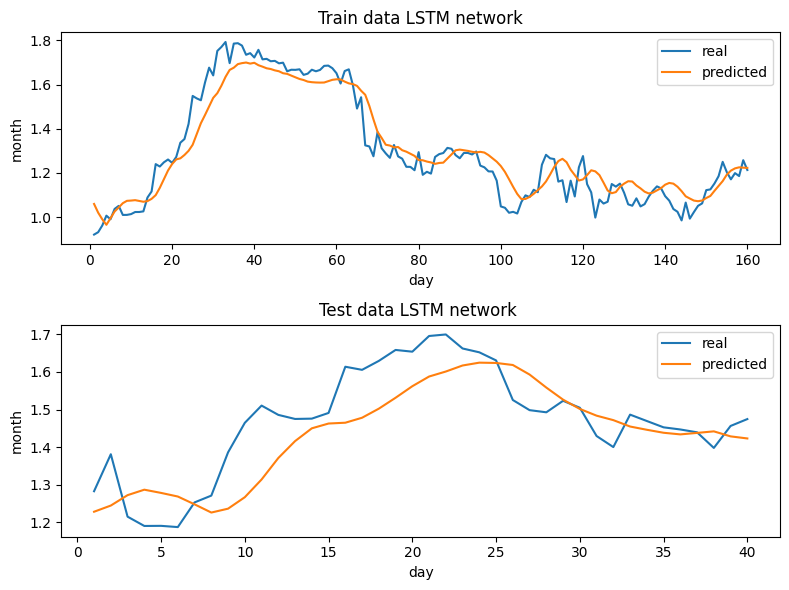

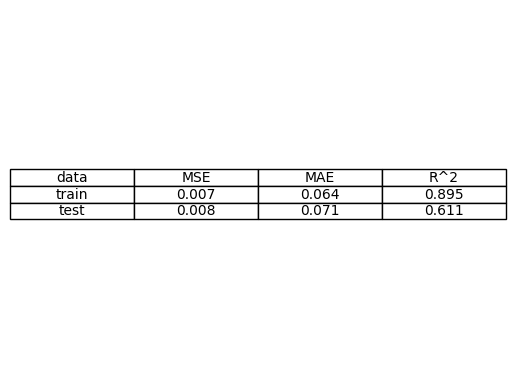

In [54]:
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)
generate_plots(y_pred_train, y_pred_test, y_train, y_test, 'Train data LSTM network', 'Test data LSTM network ', True, f'LSTM_{COMPANY}')
score_table(y_train, y_pred_train, y_test, y_pred_test, f'LSTM_table_{COMPANY}')

## Bulding Linear regression model

In [55]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

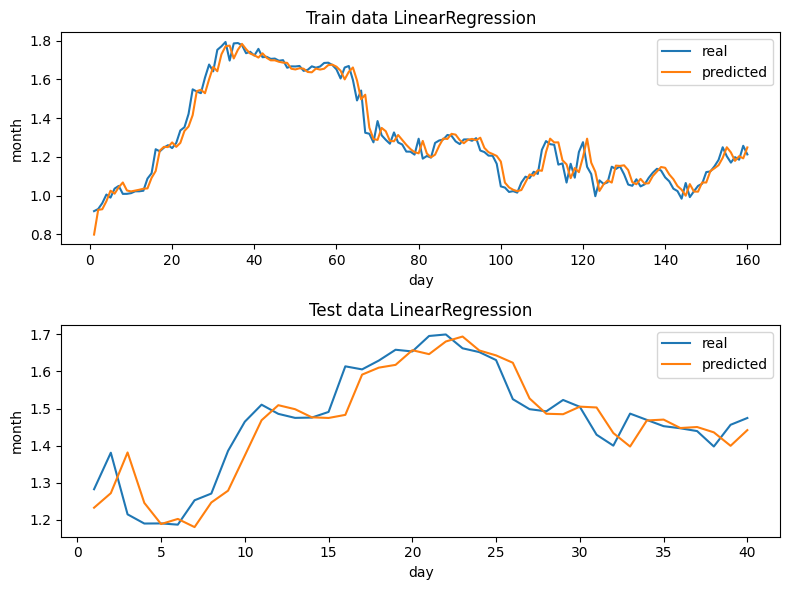

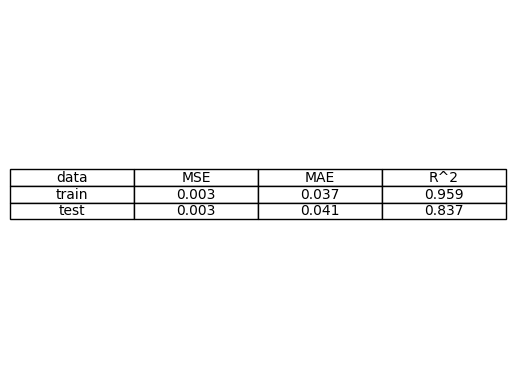

In [56]:
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)
generate_plots(y_pred_train, y_pred_test, y_train, y_test, 'Train data LinearRegression', 'Test data LinearRegression', True, f'LinearRegression_{COMPANY}')
score_table(y_train, y_pred_train, y_test, y_pred_test, f'LinearRegression_{COMPANY}')